# Bot or Not

## Authors: Arturo Esquerra and Shahbakht Hamdani
### W207 Summer 2018 Section 3

# Introduction

The present work is based on a Kaggle competition (https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot/) whose goal is to identify which users on an auction website are humans and which are bots based on their bidding history and other user features. The issue of bot detection is extremely relevant to auction websites, given that bots have become one of the main factors that have stifled the growth of auction sites over the past years by generating an unfair marketplace and damaging the consumer's trust on the site. 

There are two main types of auction bots:

* **Snipers**: Bots specialized in bidding at the last possible instant of an auction to guarantee that their owner can't be outbid and securing the auction.
* **Shills**: Bots that engage in shill bidding which is the process of bidding continuously on the owner's own auction to inflate the price and make it seem more popular than it is.

While initially auction sites relied on user reports to manually verify if a user was a bot or not, this system wasn't scaleable, therefore, as these sites gained popularity worldwide it became important to automatize this process to make bot detection more affordable, proactive, and accurate. Nowadays most auction sites use a combination of humans and Machine Learning through a process in which algorithms detect possible bot activity which is confirmed by the site's employees.

Our goal in this project is to use a combination of feature engineering and Machine Learning methods to effectively predict bot activity in order to flag suspicious user activity for further review.

## Python libraries

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import warnings

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for test/train split of the data
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore') #Filter out warning messages to increase readability

/Users/aesquerra/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/aesquerra/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Reading the data
The data is split into three files:

**bids.csv** contains information about more than 7650000 bids including: 
* bid_id: Unique id for the bid
* bidder_id – Unique identifier of a bidder (same as the bidder_id used in train.csv and test.csv)
* auction – Unique identifier of an auction
* merchandise –  The category of the auction site campaign, which means the bidder might come to this site by way of searching for "home goods" but ended up bidding for "sporting goods" - and that leads to this field being "home goods". This categorical field could be a search term, or online advertisement. 
* device – Phone model of a visitor
* time - Time that the bid is made (transformed to protect privacy).
* country - The country that the IP belongs to
* ip – IP address of a bidder (obfuscated to protect privacy).
* url - url where the bidder was referred from (obfuscated to protect privacy). 
* payment_account – Payment account associated with a bidder. These are obfuscated to protect privacy. 
* address – Mailing address of a bidder. These are obfuscated to protect privacy. 

**train.csv** contains user-level information that links the bidder_id, payment account, address, and outcome (0 for human and 1 for bots). There are a total of 2013 users in the training set.

**test.csv** contains user-level information about the bidder_id, payment account, and address. There are a total of 4700 users in the test set which doesn't have the outcome variable as final accuracy is checked through kaggle.

Therefore, to predict whether a user is a bot or not it is necessary to match the bidder id in the test or training data set to the bids made by the same bidder id on the bids data set, aggregating all the user activity in the process.

In [2]:
#Load the data
df_bids = pd.read_csv('bids.csv')
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

In [3]:
#Shape of each of the datasets
print("bids", df_bids.shape)
print("test", df_test.shape)
print("train", df_train.shape)

bids (7656334, 9)
test (4700, 3)
train (2013, 4)


## Data Preprocessing

### Missing Values

One of the main issues with user-level data is the pressence of missing values due to a lack of activity, noncompliance from the user at submiting information about their account, or errors in the system. In our case, given the public nature of the competition, we employ exclusively non personable identifiable information about their logged activity on the auction website. Nevertheless, we do have missing values from users who have had no activity and from others that have logged to ip addresses that couldn't be matched to a country. The obfuscation of the original ip address makes it impossible to find the country through packages like **ipaddress**.

In [4]:
#Not all bids have a clear country based on the IP, so we fill the NaN values with a string value that represents this behavior.
df_bids = df_bids.fillna('N/A') #Fill empty country ip addresses with N\A

### Time
The time variable is one of the most important sources of information available about bot activity: it can tell us which users are bidding on extremely short periods of time or if someone is bidding at regulat intervals of time (for example, the bot was programmed to make a bid every 5 minutes). Unfortunately, some of the information that the time of the bid could provide was lost when the variable was obfuscated to protect privacy. The time variable provided serves mainly as a measure of reference of which events happened before others (obfuscation maintained monotonicity) but its units do not correspond any used in the real world (hours, minutes, seconds, etc.). Furthermore, the analysis of the time variable shows that not all the bidding data came from the same period of time, but rather was aggregated from multiple datasets (this was confirmed by the kaggle team: https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot/discussion/13818). Therefore, given the large scale of units in which time is presented and its lack of interpretability we decide to normalize its values transforming them to z-scores. It is important to acknowledge that this isn't an ideal use of z-scores given the evidence that the data came from different periods making it have multiple high-density intervals.

([array([ 10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  11.])],
 array([  0.00000000e+00,   9.77288521e+14,   1.95457704e+15,
          2.93186556e+15,   3.90915408e+15,   4.88644261e+15,
          5.86373113e+15,   6.84101965e+15,   7.81830817e+15,
          8.79559669e+15,   9.77288521e+15]),
 <a list of 2 Lists of Patches objects>)

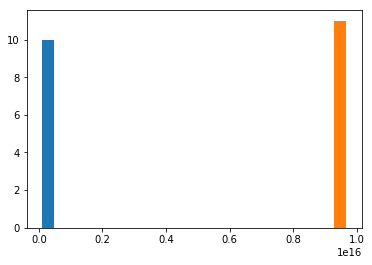

In [5]:
plt.hist(np.histogram(df_bids.time))

In [6]:
df_bids = df_bids.sort_values(by=['time'], ascending=True) #Given that bid id is just an index variable which doesn't
#represent any ordering of the data, we sort the data by the time in which the bid was made.
time = (df_bids.time - df_bids.time.mean())/df_bids.time.std() #Standardize (z-score) the time
df_bids.time = time

([array([ 6.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  1.]),
  array([ 11.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])],
 array([ -1.25817956e+00,   2.87200568e+05,   5.74402393e+05,
          8.61604219e+05,   1.14880605e+06,   1.43600787e+06,
          1.72320970e+06,   2.01041152e+06,   2.29761335e+06,
          2.58481517e+06,   2.87201700e+06]),
 <a list of 2 Lists of Patches objects>)

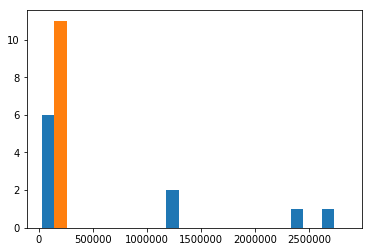

In [7]:
plt.hist(np.histogram(df_bids.time))

In [8]:
df_bids.head(10)

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
2351187,2351187,76218e14c379c12d599dae9e1c00b61a3i5b2,6hpvy,sporting goods,phone1161,-1.25818,cz,121.169.96.51,f33fl83l4vrg6is
2351202,2351202,29c103503e1d6ace5626fb07a5ab0dafrtjvs,wpee4,jewelry,phone412,-1.25818,ru,63.82.37.102,via8q041tf3xrke
2351201,2351201,0ea62aaa9c3ffcc6db584cb69c1f6c4bcripp,b6zck,mobile,phone99,-1.25818,lt,181.144.42.116,vasstdc27m7nks3
2351200,2351200,6e178db6d17d21aa88aaca5bf15c2761lc500,jqx39,jewelry,phone99,-1.25818,sa,174.12.78.255,omwhmwzvrn6ycq6
2351199,2351199,b7c4f67613c2af7e544f01359d4fccc7l5f7y,du967,office equipment,phone348,-1.25818,tr,21.10.208.37,vasstdc27m7nks3
2351198,2351198,4f532f604c53034fe8e40d8674d0746el7zei,cc5fs,jewelry,phone246,-1.25818,sa,61.127.19.247,avuxxlzolve3zg0
2351197,2351197,dc42e19537f0c918f3c102b2a153544eukabw,czikl,sporting goods,phone22,-1.25818,my,150.48.187.171,vasstdc27m7nks3
2351196,2351196,29c103503e1d6ace5626fb07a5ab0dafrtjvs,6398x,jewelry,phone20,-1.25818,th,163.163.157.17,q2tla3a4wpiyrjl
2351188,2351188,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,64uay,sporting goods,phone0,-1.25818,ke,17.120.130.121,vasstdc27m7nks3
2351194,2351194,3d7cff3dedd8a8e02dbc551c6a61da3bibbvh,5mqsv,home goods,phone4,-1.25818,vn,235.207.16.31,vasstdc27m7nks3


## Feature Engineering

One of the most important aspects of applied Machine Learning is the process of feature engineering through which the available data is used to create features that are informative and relevant to the prediction objective. This process is particularly important for our project given that the data provided through Kaggle is composed in its entirety by non personable identifiable information and is restricted to activity data of users on the auction website. Therefore, none of the initial variables is closely correlated with bot activity, but rather bots will have to be detected through their patterns and bidding activity.

### Bids
The number of bids is an important predictor of bot activity. While there might be some human heavy-users, bots (in particular shilling bots) are likely to have much more additional bids. In addition to creating a feature for the total number of bids at the user-level, we count the number of unique auctions a user placed bets in. The reasoning for this feature is that humans are likely to have balanced levels of total bids and bids per auction while bots don't (sniping bots might be used for a single auction and shills might bid a few times in a wide array of auctions to infate their price). The average numebr of bids per auction, the ratio between these two, is also included as a feature.

### Time
While the number of bids is important, their timing might be even more important as it allows us to detect suspicious bot activity such as:
* Users that are bidding at unusually short periods of time. For instance, sbiping bots might make several bids towards the final seconds of the auction to gurantee winning the product.
* Users that bid at regular amount of times (time between bids). For instance, a shill bot might be programmed to place a bid at regular periods of time.
* Unusual patterns of bids across time.
To analyze time we study the variable by itself calculating the mean, standard deviation and quantiles of the times in which they bid for any product and also by focusing on the time between bids by creating features that reflect the average time between bids, the shortest and longest period between them, as well as dispersion metrics.

### Devices
The devices used to place the bids can also contribute valuable information to detection of bots. For instance, human bidders are likely to have, at most, a handful of devices from which bids are made while bot farms usually have at their disposal multiple devices used to place bids. Therefore, the number of unique devices as well as the proportion of times the most and least likely device were used to make a bid are created from the device variable. 

### IP
Even though the actual ip address from which bids are placed is not a great predictor of bot activity as they by themselves just rely information from where the connection came, patterns on how users made bids through ip addresses can be a relevant predictor of bot activity. In particular, given that bot farms often use services to mask their ip, users with bids from many different ip addresses are suspicious. Furthermore, the proportion of times they use each ip address can give us information of whether it is a human (most of their bids will come from the same address) or not. Dispersion on the counts of this variable can also shed light on bot activity. In addition to telling the unique ip address from which a bid was made, the ip variable, which is provided in its IPV4 form, contains additional information in each of its four sub-addresses which could help us detect suspicious activity of users on wider areas than the specific complete ip code. Therefore, we apply a decomposition of the IPV4 address.

### Country
Country information is closely related to ip data and can help us raise flags on bot users who tend to use proxies or VPNs to hide their connection information in which case they migh appear to make bids from many different countries. Variability and relative frequencies on country information is also very relevant. Moreover, we believe that some countries might be more likely to host bots than other due to cheaper opertive costs. Therefore, we add a dummy variable of the country in which most (mode) of the bids were placed on.

### URL
The url gives us referral information from which site the user came before he made the bid. We believe that humans are likely to have a distinct behavior from bots as the former might get to the auction after exploring the site (they are likely to have many unique url addresses) while bots are programmed to directly access the auction in which they were programmed to bid on. The obfuscation of this variable forces us to rely on unique counts, relative frequencies of access, and dispersion metrics rather than using additional information about the referral sites (how common it is, its url composition, pressence of tags, etc.).

### Merchandise
The merchandise variable does not tells us the category of the product in which the bid was placed but rather gives us information about what the bidder was looking for prior to making a bid. Therefore, the variable can help us reinforce the information from the url series by giving us insight on whether the consumer typically looks for the same category of products (likely a human behavior) or if they look for a wide variety of categories (likely bot behavior). 

### Winners
One of the main variables that can help us predict whether a user is a bot (a snipping bot) is the amount and rate of auctions in which the user won. With this in mind, we develop a feature that will declare a user the winner of the auction if they made the last bid in the history. It important to mention that this feature relies on two assumptions: 
* There was no reserve bid (the user's bid might have been smaller than the reserve bid in which case they wouldn't have won)
* All auctions start and end during the period in which we have data. In reality it is possible that some auctions could have ended after our last bid data and that a different user could have won.

### Features that didn't work
The main set of features that were attempted but didn't lead to better results are those created from the merchandise variable. In particular, we hypothesized that calculating the amount of times each user made bids on each of the different categories could improve accuracy by highlighting those categories that are most likely to be targeted by bots. However, the fact that the merchandise variable is not an indicator of the auction's category but rather a variable related to search or ad terms that lead to the auction, made these variables less useful to detect bots. Another approach that proved unfruitful was related to using the most commonly used ip as a predictor. Unfortunately, the large amount of unique ip addresses lead to a very sparse dummy representation which increased our concerns for the curse of dimensionality beyond the additional predictive power that this variable could give us. Finally, the address and payment information in the train.csv and test.csv sets proved useless probably due to their obfuscation which contributed to hide any patters we could have find on them.

In [9]:
#Splitting ip address into sub-addresses
ips = df_bids.ip.str.split(".", n=4, expand=True)
ips.columns=['p1','p2','p3','p4']
df_bids = df_bids.join(ips, how='outer')

In [10]:
#Winners are those who enetered the last recorded bid in an auction
winners = df_bids.groupby('auction').time.max()

In [11]:
def user_level(bidder_id):
    
    count_bids = 0 #Count the number of bids per bidder_id
    
    count_unique_auctions = 0 #Count the number of unique auctions per bidder_id
    
    max_freq_auction = 0 #Proportion of user's bids that the most popular auction was bid on
    min_freq_auction = 0 #Proportion of user's bids that the least popular auction was bid on
    mean_freq_auction = 0 #Average of the proportion of users bids (on average, the user bids on an auction x%)
    median_freq_auction = 0 #Median of the proportion of users bids 
    sd_freq_auction = 0 #Standrd Deviation of proportion of users bids 
    
    #Statistics of the time in which bids were made
    mean_time = 0 #Mean time
    sd_time = 0 #Standard Deviation of the time
    q1_time = 0 #First quartile of time  
    q2_time = 0 #Second/Median quartile of time  
    q3_time = 0 #Third quartile of time  
    
    #Statistics of the time between bids of the same bidder
    min_time_between_bids = 0
    max_time_between_bids = 0
    mean_time_between_bids = 0
    std_time_between_bids = 0
    q1_time_between_bids = 0
    q2_time_between_bids = 0
    q3_time_between_bids = 0
    
    #Statistics about device usage
    count_unique_device = 0 #Number of bids from unique devices
    max_freq_device = 0
    min_freq_device = 0
    mean_freq_device = 0
    median_freq_device = 0
    sd_freq_device = 0
    
    #Statistics about the ip used by the consumer
    count_bids_unique_ip = 0 #Number of bids from unique ip addresses
    max_freq_ip = 0
    min_freq_ip = 0
    mean_freq_ip = 0
    median_freq_ip = 0
    sd_freq_ip = 0
    mode_ip = 0
    
    count_ip_p1_unique = 0
    mode_ip_p1 = 0
    
    count_ip_p2_unique = 0
    mode_ip_p2 = 0
    
    count_ip_p3_unique = 0
    mode_ip_p3 = 0

    count_ip_p4_unique = 0
    mode_ip_p4 = 0
    
    count_bids_unique_countries = 0 #Number of unique countries where the bid was made
    max_freq_country = 0
    min_freq_country = 0
    mean_freq_country = 0
    median_freq_country = 0
    sd_freq_country = 0
    mode_country = 0
    
    count_bids_unique_url = 0 #Number of unique referral urls
    max_freq_url = 0
    min_freq_url = 0
    mean_freq_url = 0
    median_freq_url = 0
    sd_freq_url = 0
    
    count_unique_merch = 0 #Number of unique categories in which the bidder made a bid
    max_freq_merch = 0
    min_freq_merch = 0
    mean_freq_merch = 0
    median_freq_merch = 0
    sd_freq_merch = 0
    
    avg_bids_per_auction = 0 #Average number of bids per auction
    
    #count_jewelry = 0
    #count_furniture = 0
    #count_homegoods = 0
    #count_mobile = 0
    #count_sportinggood = 0
    #count_officeequipment = 0
    #count_computers = 0
    #count_booksmusic = 0
    #count_clothing = 0
    #count_autoparts = 0
    
    winner_auctions = 0
    winner_rate = 0
    
    df_aux = df_bids.loc[df_bids['bidder_id'] == bidder_id]
    df_diff_time = df_aux.time.diff()
    
    count_bids = df_aux.shape[0]
    
    count_unique_auctions = len(df_aux.auction.unique())
    
    max_freq_auction = (df_aux.auction.value_counts()/df_aux.auction.shape)[0]
    min_freq_auction = (df_aux.auction.value_counts()/df_aux.auction.shape)[-1]
    mean_freq_auction = np.mean(df_aux.auction.value_counts()/df_aux.auction.shape)
    median_freq_auction = np.median(df_aux.auction.value_counts()/df_aux.auction.shape)
    sd_freq_auction = np.std(df_aux.auction.value_counts()/df_aux.auction.shape)
    
    mean_time = df_aux.time.mean()
    
    sd_time = df_aux.time.std(ddof=0)
    
    q1_time = df_aux.time.quantile(0.25)
    q2_time = df_aux.time.quantile(0.5)
    q3_time = df_aux.time.quantile(0.75)

    if count_bids >= 2:
        min_time_between_bids = df_diff_time.min()
        max_time_between_bids = df_diff_time.max()
        mean_time_between_bids = df_diff_time.mean()
        std_time_between_bids = df_diff_time.std()
        q1_time_between_bids = df_diff_time.quantile(0.25)
        q2_time_between_bids = df_diff_time.quantile(0.5)
        q3_time_between_bids = df_diff_time.quantile(0.75)
    if count_bids < 2:
        min_time_between_bids = df_aux.time.mean()
        max_time_between_bids = df_aux.time.mean()
        mean_time_between_bids = df_aux.time.mean()
        std_time_between_bids = 0
        q1_time_between_bids = df_aux.time.mean()
        q2_time_between_bids = df_aux.time.mean()
        q3_time_between_bids = df_aux.time.mean()
        
    
    count_unique_device = len(df_aux.device.unique())

    max_freq_device = (df_aux.device.value_counts()/df_aux.device.shape)[0]
    min_freq_device = (df_aux.device.value_counts()/df_aux.device.shape)[-1]
    mean_freq_device = np.mean(df_aux.device.value_counts()/df_aux.device.shape)
    median_freq_device = np.median(df_aux.device.value_counts()/df_aux.device.shape)
    sd_freq_device = np.std(df_aux.device.value_counts()/df_aux.device.shape)
    
    count_bids_unique_ip = len(df_aux.ip.unique())
    
    max_freq_ip = (df_aux.ip.value_counts()/df_aux.ip.shape)[0]
    min_freq_ip = (df_aux.ip.value_counts()/df_aux.ip.shape)[-1]
    mean_freq_ip = np.mean(df_aux.ip.value_counts()/df_aux.ip.shape)
    median_freq_ip = np.median(df_aux.ip.value_counts()/df_aux.ip.shape)
    sd_freq_ip = np.std(df_aux.ip.value_counts()/df_aux.ip.shape)
    mode_ip = df_aux.ip.mode()[0]
    
    count_ip_p1_unique = len(df_aux.p1.unique())
    mode_ip_p1 = df_aux.p1.mode()[0]
    
    count_ip_p2_unique = len(df_aux.p2.unique())
    mode_ip_p2 = df_aux.p2.mode()[0]
    
    count_ip_p3_unique = len(df_aux.p3.unique())
    mode_ip_p3 = df_aux.p3.mode()[0]

    count_ip_p4_unique = len(df_aux.p4.unique())
    mode_ip_p4 = df_aux.p4.mode()[0]
    
    count_bids_unique_countries = len(df_aux.country.unique())
    
    max_freq_country = (df_aux.country.value_counts()/df_aux.country.shape)[0]
    min_freq_country = (df_aux.country.value_counts()/df_aux.country.shape)[-1]
    mean_freq_country = np.mean(df_aux.country.value_counts()/df_aux.country.shape)
    median_freq_country = np.median(df_aux.country.value_counts()/df_aux.country.shape)
    sd_freq_country = np.std(df_aux.country.value_counts()/df_aux.country.shape)
    mode_country = df_aux.country.mode()[0]
    
    count_bids_unique_url = len(df_aux.url.unique())
    
    max_freq_url = (df_aux.url.value_counts()/df_aux.url.shape)[0]
    min_freq_url = (df_aux.url.value_counts()/df_aux.url.shape)[-1]
    mean_freq_url = np.mean(df_aux.url.value_counts()/df_aux.url.shape)
    median_freq_url = np.median(df_aux.url.value_counts()/df_aux.url.shape)
    sd_freq_url = np.std(df_aux.url.value_counts()/df_aux.url.shape)
    
    count_unique_merch = len(df_aux.merchandise.unique())

    max_freq_merch = (df_aux.merchandise.value_counts()/df_aux.merchandise.shape)[0]
    min_freq_merch = (df_aux.merchandise.value_counts()/df_aux.merchandise.shape)[-1]
    mean_freq_merch = np.mean(df_aux.merchandise.value_counts()/df_aux.merchandise.shape)
    median_freq_merch = np.median(df_aux.merchandise.value_counts()/df_aux.merchandise.shape)
    sd_freq_merch = np.std(df_aux.merchandise.value_counts()/df_aux.merchandise.shape)
    
        
    avg_bids_per_auction = count_bids / count_unique_auctions
    
    #count_jewelry = sum(df_aux.merchandise == 'jewelry')
    #count_furniture = sum(df_aux.merchandise == 'furniture')
    #count_homegoods = sum(df_aux.merchandise == 'home goods')
    #count_mobile = sum(df_aux.merchandise == 'mobile')
    #count_sportinggood = sum(df_aux.merchandise == 'sporting good')
    #count_officeequipment = sum(df_aux.merchandise == 'office equipment')
    #count_computers = sum(df_aux.merchandise == 'computers')
    #count_booksmusic = sum(df_aux.merchandise == 'books and music')
    #count_clothing = sum(df_aux.merchandise == 'clothing')
    #count_autoparts = sum(df_aux.merchandise == 'auto parts')
        
    for time in df_aux.groupby('auction').time.max():
        for time2 in winners:        
            if time == time2:
                winner_auctions = winner_auctions + 1
    
    if winner_auctions == 0:
        winner_rate = 0
    if winner_auctions > 0:
        winner_rate = winner_auctions / count_unique_auctions
        
    return([count_bids,
            count_unique_auctions,
            max_freq_auction,
            min_freq_auction,
            mean_freq_auction,
            median_freq_auction,
            sd_freq_auction,
            mean_time,
            sd_time,
            q1_time,
            q2_time,
            q3_time,
            min_time_between_bids,
            max_time_between_bids,
            mean_time_between_bids,
            std_time_between_bids,
            q1_time_between_bids,
            q2_time_between_bids,
            q3_time_between_bids,
            count_unique_device,
            max_freq_device,
            min_freq_device,
            mean_freq_device,
            median_freq_device,
            sd_freq_device,
            count_bids_unique_ip,
            max_freq_ip,
            min_freq_ip,
            mean_freq_ip,
            median_freq_ip,
            sd_freq_ip,
            mode_ip,
            count_ip_p1_unique,
            mode_ip_p1,
            count_ip_p2_unique,
            mode_ip_p2,
            count_ip_p3_unique,
            mode_ip_p3,
            count_ip_p4_unique,
            mode_ip_p4,
            count_bids_unique_countries,
            max_freq_country,
            min_freq_country,
            mean_freq_country,
            median_freq_country,
            sd_freq_country,
            mode_country,
            count_bids_unique_url,
            max_freq_url,
            min_freq_url,
            mean_freq_url,
            median_freq_url,
            sd_freq_url,
            count_unique_merch,
            max_freq_merch,
            min_freq_merch,
            mean_freq_merch,
            median_freq_merch,
            sd_freq_merch,
            avg_bids_per_auction,
            winner_auctions,
            winner_rate]
          )

In [12]:
#Create features for each bidder_id
Features = []
BidderID = []

for bidder in df_bids.bidder_id.unique():
    BidderID.append(bidder)
    Features.append(user_level(bidder))

## Data Processing

Data processing consisted mainly on joining the features generated from the bids.csv dataset with the training and test sets by matching the bidder_id. During this process we notice that some users in the training and test sets (30 and 70 users respectively) have no bidding activity which means that they aren't present on the bids dataset. The feature values are zero-filled for this users as they are unlikely to be robots given their lack of activity. 

In [13]:
#Set indices
df_train = df_train.set_index('bidder_id')
df_test = df_test.set_index('bidder_id')

### Merging the training set

In [14]:
columns = ['count_bids',
            'count_unique_auctions',
            'max_freq_auction',
            'min_freq_auction',
            'mean_freq_auction',
            'median_freq_auction',
            'sd_freq_auction',
            'mean_time',
            'sd_time',
            'q1_time',
            'q2_time',
            'q3_time',
            'min_time_between_bids',
            'max_time_between_bids',
            'mean_time_between_bids',
            'std_time_between_bids',
            'q1_time_between_bids',
            'q2_time_between_bids',
            'q3_time_between_bids',
            'count_unique_device',
            'max_freq_device',
            'min_freq_device',
            'mean_freq_device',
            'median_freq_device',
            'sd_freq_device',
            'count_bids_unique_ip',
            'max_freq_ip',
            'min_freq_ip',
            'mean_freq_ip',
            'median_freq_ip',
            'sd_freq_ip',
            'mode_ip',
            'count_ip_p1_unique',
            'mode_ip_p1',
            'count_ip_p2_unique',
            'mode_ip_p2',
            'count_ip_p3_unique',
            'mode_ip_p3',
            'count_ip_p4_unique',
            'mode_ip_p4',
            'count_bids_unique_countries',
            'max_freq_country',
            'min_freq_country',
            'mean_freq_country',
            'median_freq_country',
            'sd_freq_country',
            'mode_country',
            'count_bids_unique_url',
            'max_freq_url',
            'min_freq_url',
            'mean_freq_url',
            'median_freq_url',
            'sd_freq_url',
            'count_unique_merch',
            'max_freq_merch',
            'min_freq_merch',
            'mean_freq_merch',
            'median_freq_merch',
            'sd_freq_merch',
            'avg_bids_per_auction',
            'winner_auctions',
            'winner_rate']

merged = pd.DataFrame(Features, index = BidderID, columns = columns)
merged.index.name = 'bidder_id'

merged = pd.get_dummies(merged, columns=['mode_country'])

df_train_merged = df_train.join(merged, how='outer')

df_train_merged[merged.columns.values] = df_train_merged[merged.columns.values].fillna(value=0)

print(df_train_merged.isnull().sum(axis = 0))
#print(len(df_train_merged))

df_train_merged = df_train_merged.dropna()
df_train_merged.head()
#We can-t match 29 bidder ids from the train set to bids and 70 from test to bids

payment_account           4630
address                   4630
outcome                   4630
count_bids                   0
count_unique_auctions        0
max_freq_auction             0
min_freq_auction             0
mean_freq_auction            0
median_freq_auction          0
sd_freq_auction              0
mean_time                    0
sd_time                      0
q1_time                      0
q2_time                      0
q3_time                      0
min_time_between_bids        0
max_time_between_bids        0
mean_time_between_bids       0
std_time_between_bids        0
q1_time_between_bids         0
q2_time_between_bids         0
q3_time_between_bids         0
count_unique_device          0
max_freq_device              0
min_freq_device              0
mean_freq_device             0
median_freq_device           0
sd_freq_device               0
count_bids_unique_ip         0
max_freq_ip                  0
                          ... 
mode_country_np              0
mode_cou

,payment_account,address,outcome,count_bids,count_unique_auctions,max_freq_auction,min_freq_auction,mean_freq_auction,median_freq_auction,sd_freq_auction,...,mode_country_tw,mode_country_tz,mode_country_ua,mode_country_uk,mode_country_us,mode_country_vn,mode_country_ye,mode_country_za,mode_country_zm,mode_country_zw
bidder_id,,,,,,,,,,,,,,,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,a3d2de7675556553a5f08e4c88d2c228iiasc,a3d2de7675556553a5f08e4c88d2c2282aj35,0.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0030a2dd87ad2733e0873062e4f83954mkj86,a3d2de7675556553a5f08e4c88d2c228jem8t,f3bc67b04b43c3cebd1db5ed4941874c9br67,0.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00a0517965f18610417ee784a05f494d4dw6e,52743ba515e9c1279ac76e19f00c0b001p3pm,7578f951008bd0b64528bf81b8578d5djy0uy,0.0,141.0,74.0,0.049645,0.007092,0.013514,0.007092,0.009973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00cc97158e6f4cb8eac3c0075918b7ffi5k8o,cdd7b79f306a2b331ab5fb6f19d6edebllbjt,b3d2348e65b940c31bfceeee5a1f9dabels6u,0.0,3.0,3.0,0.333333,0.333333,0.333333,0.333333,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01067975436d123f717ee5aba0dd4bbfa0937,a3d2de7675556553a5f08e4c88d2c228d0upt,ca7ebbf817ced6e7194200eb690eda41u4mda,0.0,543.0,17.0,0.957643,0.001842,0.058824,0.001842,0.224715,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Merging the test set

In [15]:
df_test_merged = df_test.join(merged, how='outer')
df_test_merged[merged.columns.values] = df_test_merged[merged.columns.values].fillna(value=0)
df_test_merged = df_test_merged.dropna()
print(df_test_merged.isnull().sum(axis = 0))
#print(df_test_merged.shape)
df_test_merged.head()

payment_account           0
address                   0
count_bids                0
count_unique_auctions     0
max_freq_auction          0
min_freq_auction          0
mean_freq_auction         0
median_freq_auction       0
sd_freq_auction           0
mean_time                 0
sd_time                   0
q1_time                   0
q2_time                   0
q3_time                   0
min_time_between_bids     0
max_time_between_bids     0
mean_time_between_bids    0
std_time_between_bids     0
q1_time_between_bids      0
q2_time_between_bids      0
q3_time_between_bids      0
count_unique_device       0
max_freq_device           0
min_freq_device           0
mean_freq_device          0
median_freq_device        0
sd_freq_device            0
count_bids_unique_ip      0
max_freq_ip               0
min_freq_ip               0
                         ..
mode_country_np           0
mode_country_om           0
mode_country_pa           0
mode_country_ph           0
mode_country_pk     

,payment_account,address,count_bids,count_unique_auctions,max_freq_auction,min_freq_auction,mean_freq_auction,median_freq_auction,sd_freq_auction,mean_time,...,mode_country_tw,mode_country_tz,mode_country_ua,mode_country_uk,mode_country_us,mode_country_vn,mode_country_ye,mode_country_za,mode_country_zm,mode_country_zw
bidder_id,,,,,,,,,,,,,,,,,,,,,
002d229ffb247009810828f648afc2ef593rb,a3d2de7675556553a5f08e4c88d2c2288z8oy,111d4514cb2db9cc0aaf1ae65b39e70aq52r7,2.0,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.309707,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,a3d2de7675556553a5f08e4c88d2c22841s2u,a3d2de7675556553a5f08e4c88d2c228iami0,3.0,3.0,0.333333,0.333333,0.333333,0.333333,0.000000,-0.300512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00486a11dff552c4bd7696265724ff81yeo9v,a3d2de7675556553a5f08e4c88d2c228atvf2,8eb7a11dcccf50edc9d56f0f5ddb4806nfli0,20.0,13.0,0.150000,0.050000,0.076923,0.050000,0.031716,-0.833289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0051aef3fdeacdadba664b9b3b07e04e4coc6,a3d2de7675556553a5f08e4c88d2c2284lsdz,3a416c981f70e1f31f997e07d0fe68b2zippg,68.0,5.0,0.602941,0.014706,0.200000,0.029412,0.232446,1.198452,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0053b78cde37c4384a20d2da9aa4272aym4pb,14d7d988202b03ea34143b1fd62c4bb3y9n2h,d2047f8aafcdbe575417da7ab673cefbc5p7x,10939.0,408.0,0.040954,0.000091,0.002451,0.000274,0.006362,-0.580368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Mode ip is removed given the inability of sklearn models to natively incorporate non-numeric data which means that hundreds of dummy variables would have been needed to incorporate this variable. This decision was made in order to avoid issues related to the curse of dimensionality.

In [16]:
#df_train_merged = pd.get_dummies(df_train_merged, columns=['mode_country'])
#df_test_merged = pd.get_dummies(df_test_merged, columns=['mode_country'])
df_train_merged = df_train_merged.drop(['mode_ip'], axis=1)
df_test_merged = df_test_merged.drop(['mode_ip'], axis=1)

Final size and shape of the training and test sets

In [17]:
df_train_merged.shape

(2013, 162)

In [18]:
df_test_merged.shape

(4700, 161)

## Model Fitting 

The process of model fitting faces several important challenges, mainly:
* **Small training set:** The training data in the competition provides only 2013 observations (30 have no bids values) which need to be split into train and test set (with outcome values) to fit the models. This leaves us with few observations and an important decision to make in terms of the size of the training set: devote most of the observations to the training set and risk overfitting or split the data more evenly which leaves us with few entries to fit the model. Furthermore, predictions must be done on a set of 4700 test observations.
* **Imbalance:** One of the main challenges of the project is the imbalance between humans and bots in the training set with only 103 bidders flagged as bots and 1910 flagged as humans. This motivates the use of several Machine Learning techniques to account and penalize the imbalance, namely:
    * Cross validation and K Fold Cross validation
    * Scoring metrics that penalize the imbalance such as f1_weighted and roc_auc
    * Balanced class weights in which the values of the outcome are automatically adjusted to weight inversely to proportional class frequencies.
    * Stratification of the randomization of training and test observations from the training set which guarantees that the same proportion of outcomes hold.
* **Scale**: The size of the project makes it very computationally intensive and time consuming. With the processing power available at consumer computers, models can take hours to run limiting the amount of adjustments that can be made given the time constraints.

The modelling strategy consists of testing a wide variety of features on robust predictive models whose hyperparameters are tuned through GridsearchCV, in particular:
* **Logistic regression (l1 and l2 penalty)**: Given the approach to use a large amount of features the flexibility offered by l1 and l2 penalties to shrink features (particularly l1 penalty), logistic regression can help us refine our features and create accurate predictions.
* **Support Vector Machines (sigmoid and rbf)**: The fact that the project's objective is to provide accurate predictions of bot and human activity and not interpretability, SVMs offer good flexibility and potentially good performance.
* **Random Forests**: Random Forests are our best candidate for predictions given their high performance and robustness to overfitting.

In [19]:
train, test = train_test_split(df_train_merged, test_size=0.2, random_state = 0, stratify = df_train_merged[df_train_merged.columns[2]].as_matrix())

In [20]:
print(train.shape, test.shape)

(1610, 162) (403, 162)


In [21]:
#Create matrices with relevant variables for modelling
train_matrix_all = train[train.columns[3:]].as_matrix()
train_labels_all = train[train.columns[2]].as_matrix()
test_matrix_all = test[test.columns[3:]].as_matrix()
test_labels_all = test[test.columns[2]].as_matrix()

In [22]:
#All training set
train_matrix_all_data = df_train_merged[df_train_merged.columns[3:]].as_matrix()
train_labels_all_data = df_train_merged[df_train_merged.columns[2]].as_matrix()

In [23]:
test_set_matrix = df_train_merged[df_train_merged.columns[3:]].as_matrix()

## Logistic Regressions

### Logistic Regression using L2 penalty

The optimal value for C is: 3.0

Confusion Matrix:
[[380   2]
 [ 16   5]]

Classification Report:
             precision    recall  f1-score   support

        0.0       0.96      0.99      0.98       382
        1.0       0.71      0.24      0.36        21

avg / total       0.95      0.96      0.94       403


Area under ROC curve:
0.616429818

ROC Curve



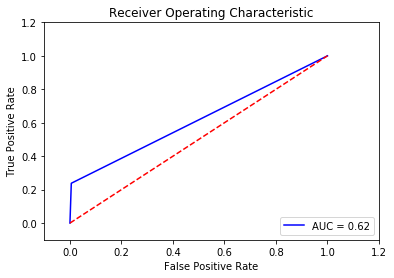

In [24]:
#Logistic Regression with l2 penalty
C_range = np.concatenate([np.arange(0.001,0.002,0.001), np.arange(0.01,0.26,0.01), np.arange(.3,1.1,.1), np.arange(2,6,1)]) 
C_grid = dict(C=C_range)
Logisticgridl2 = GridSearchCV(LogisticRegression(penalty="l2"), param_grid=C_grid, scoring='f1_weighted')
Logisticgridl2.fit(train_matrix_all, train_labels_all)

#Report the best value for C based on GridSearchCV's grid and objective parameter (f1_weighted)
print("The optimal value for C is:", Logisticgridl2.best_params_["C"])

Logisticgridl2_predict = Logisticgridl2.predict(test_matrix_all)
print("\nConfusion Matrix:")
print(confusion_matrix(test_labels_all, Logisticgridl2_predict))
print("\nClassification Report:")
print(metrics.classification_report(test_labels_all, Logisticgridl2_predict))
print("\nArea under ROC curve:")
print(metrics.roc_auc_score(test_labels_all, Logisticgridl2_predict))

print("\nROC Curve\n")
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_labels_all, Logisticgridl2_predict)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Logistic Regression using L1 penalty

The logistic model with l1 penalty outperforms the model with l2 penalty due to the flexibility of the former to shrink some of the estimates towards zero.

The optimal value for C is: 5.0

Confusion Matrix:
[[375   7]
 [ 14   7]]

Classification Report:
             precision    recall  f1-score   support

        0.0       0.96      0.98      0.97       382
        1.0       0.50      0.33      0.40        21

avg / total       0.94      0.95      0.94       403


Area under ROC curve:
0.657504363002

ROC Curve



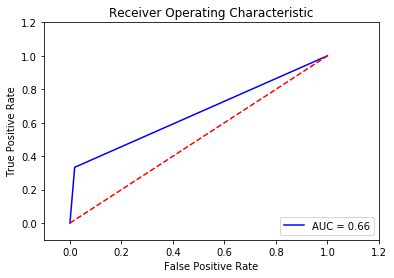

In [25]:
#Logistic Regression using L1 penalty

Logisticgridl1 = GridSearchCV(LogisticRegression(penalty="l1"), param_grid=C_grid, scoring='f1_weighted')
Logisticgridl1.fit(train_matrix_all, train_labels_all)

#Report the best value for C based on GridSearchCV's grid and objective parameter (f1_weighted)
print("The optimal value for C is:", Logisticgridl1.best_params_["C"])

Logisticgridl1_predict = Logisticgridl1.predict(test_matrix_all)
print("\nConfusion Matrix:")
print(confusion_matrix(test_labels_all, Logisticgridl1_predict))
print("\nClassification Report:")
print(metrics.classification_report(test_labels_all, Logisticgridl1_predict))
print("\nArea under ROC curve:")
print(metrics.roc_auc_score(test_labels_all, Logisticgridl1_predict))

print("\nROC Curve\n")
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_labels_all, Logisticgridl1_predict)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Support Vector Machine Models

Optimal parameters: {'C': 0.001, 'gamma': 0.001}

Confusion Matrix:
[[382   0]
 [ 21   0]]

Classification Report:
             precision    recall  f1-score   support

        0.0       0.95      1.00      0.97       382
        1.0       0.00      0.00      0.00        21

avg / total       0.90      0.95      0.92       403


Area under ROC curve:
0.5

ROC Curve



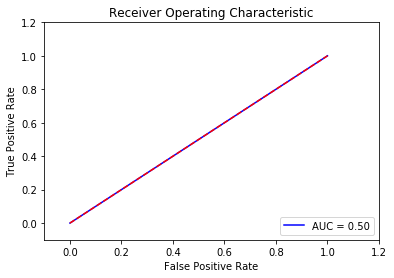

In [26]:
#Sigmoid SVM
C_grid = [0.001, 0.01, 0.1, 1, 10]
gammas_grid = [0.001, 0.01, 0.1, 1]

grid_sigmoid = {'C': C_grid, 'gamma' : gammas_grid}
grid_search_sigmoid = GridSearchCV(SVC(kernel='sigmoid', class_weight = 'balanced'), param_grid = grid_sigmoid, scoring='f1_weighted', cv = 10)
grid_search_sigmoid.fit(train_matrix_all, train_labels_all)
print("Optimal parameters:", grid_search_sigmoid.best_params_)

grid_search_sigmoid_predict = grid_search_sigmoid.predict(test_matrix_all)

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels_all, grid_search_sigmoid_predict))
print("\nClassification Report:")
print(metrics.classification_report(test_labels_all, grid_search_sigmoid_predict))
print("\nArea under ROC curve:")
print(metrics.roc_auc_score(test_labels_all, grid_search_sigmoid_predict))

print("\nROC Curve\n")
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_labels_all, grid_search_sigmoid_predict)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Optimal parameters: {'C': 0.001, 'gamma': 0.001}

Confusion Matrix:
[[382   0]
 [ 21   0]]

Classification Report:
             precision    recall  f1-score   support

        0.0       0.95      1.00      0.97       382
        1.0       0.00      0.00      0.00        21

avg / total       0.90      0.95      0.92       403


Area under ROC curve:
0.5

ROC Curve



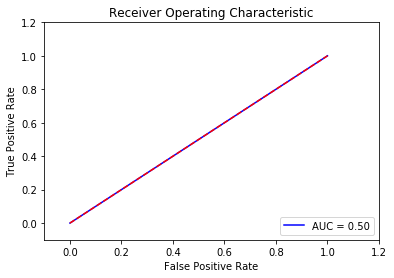

In [27]:
# RBF SVM

C_grid = [0.001, 0.01, 0.1, 1, 10]
gammas_grid = [0.001, 0.01, 0.1, 1]

grid_rbf = {'C': C_grid, 'gamma' : gammas_grid}
grid_search_rbf = GridSearchCV(SVC(kernel='rbf', class_weight = 'balanced'), param_grid = grid_rbf, scoring='f1_weighted', cv = 10)
grid_search_rbf.fit(train_matrix_all, train_labels_all)
print("Optimal parameters:", grid_search_rbf.best_params_)

grid_search_rbf_predict = grid_search_rbf.predict(test_matrix_all)

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels_all, grid_search_rbf_predict))
print("\nClassification Report:")
print(metrics.classification_report(test_labels_all, grid_search_rbf_predict))
print("\nArea under ROC curve:")
print(metrics.roc_auc_score(test_labels_all, grid_search_rbf_predict))

print("\nROC Curve\n")
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_labels_all, grid_search_rbf_predict)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forests

Optimal parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 400}

Confusion Matrix:
[[380   2]
 [ 16   5]]

Classification Report:
             precision    recall  f1-score   support

        0.0       0.96      0.99      0.98       382
        1.0       0.71      0.24      0.36        21

avg / total       0.95      0.96      0.94       403


Area under ROC curve:
0.616429818

ROC Curve



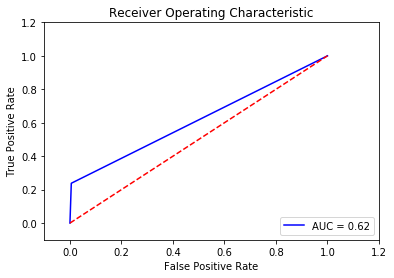

In [28]:
RFC_penalized=RandomForestClassifier(class_weight='balanced')
param_grid = { 
    'n_estimators': [10,50,100,150,200,250,300,350,400,450,500],
    'max_features': ['auto', 'log2'],
    'max_depth' : [1,2,4,6,8,10,15,20,25,50,100],
    'criterion' :['gini', 'entropy']
}
CV_RFC_penalized = GridSearchCV(estimator=RFC_penalized, param_grid=param_grid, cv= 10, scoring='f1_weighted')
CV_RFC_penalized.fit(train_matrix_all, train_labels_all)
print("Optimal parameters:", CV_RFC_penalized.best_params_)

CV_RFC_penalized_predict = CV_RFC_penalized.predict(test_matrix_all)

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels_all, CV_RFC_penalized_predict))
print("\nClassification Report:")
print(metrics.classification_report(test_labels_all, CV_RFC_penalized_predict))
print("\nArea under ROC curve:")
print(metrics.roc_auc_score(test_labels_all, CV_RFC_penalized_predict))

print("\nROC Curve\n")
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_labels_all, CV_RFC_penalized_predict)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}

Confusion Matrix:
[[375   7]
 [ 14   7]]

Classification Report:
             precision    recall  f1-score   support

        0.0       0.96      0.98      0.97       382
        1.0       0.50      0.33      0.40        21

avg / total       0.94      0.95      0.94       403


Area under ROC curve:
0.657504363002

ROC Curve



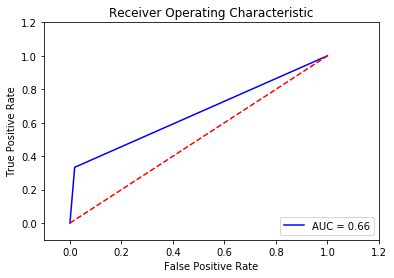

In [32]:
RFC_penalized_kfold=RandomForestClassifier(class_weight='balanced')
param_grid = { 
    'n_estimators': [10,50,100,150,200,250,300,350,400,450,500],
    'max_features': ['auto', 'log2'],
    'max_depth' : [1,2,4,6,8,10,15,20,25,50,100],
    'criterion' :['gini', 'entropy']
}
CV_RFC_penalized_kfold = GridSearchCV(estimator=RFC_penalized_kfold, param_grid=param_grid, cv= StratifiedKFold(train_labels_all, 5), scoring='f1_weighted')
CV_RFC_penalized_kfold.fit(train_matrix_all, train_labels_all)
print(CV_RFC_penalized_kfold.best_params_)

CV_RFC_penalized_kfold_predict = CV_RFC_penalized_kfold.predict(test_matrix_all)

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels_all, CV_RFC_penalized_kfold_predict))
print("\nClassification Report:")
print(metrics.classification_report(test_labels_all, CV_RFC_penalized_kfold_predict))
print("\nArea under ROC curve:")
print(metrics.roc_auc_score(test_labels_all, CV_RFC_penalized_kfold_predict))

print("\nROC Curve\n")
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_labels_all, CV_RFC_penalized_kfold_predict)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Prediction of Values in the test set (Kaggle)

In [30]:
#Prediction of test values
#df_test_merged

test_set_matrix = df_test_merged[df_test_merged.columns[2:]].as_matrix()

CV_RFC_penalized_predict_test = CV_RFC_penalized_kfold.predict(test_set_matrix)

In [31]:
predictions = pd.DataFrame(CV_RFC_penalized_predict_test, index = df_test_merged.index, columns = ['prediction'])
predictions.to_csv('submission_new4.csv', index = True, encoding='utf-8')
#df_train_merged.to_csv('train_merged_data.csv', index = True, encoding='utf-8')

## Conclusions

The main takeaway from the project is the immense importance of feature selection on applied Machine Learning projects. While the model selection and parameter tuning can improve accuracy, generating and selecting the right features are essential for a successful predictive model. Furthermore, we learned that one of the main challenges of successful feature engineering is that a large amount of knowledge about the phenomenon under study is needed in order to generate the relevant features. In particular, we noticed that most contestants on the Kaggle competition used the same models (Random Forests were the most popular ones by far) but the difference in their rates of success came from the features they used. 

Another important insight was how to deal with imbalanced data which increases the complexity of the models especially if one of the outcomes is much more important to predict than the other (in our case predicting robots). Specifically, unpenalized models tended to predict that all cases were human which lead to high accuracy rates (since 1910 cases of our training set were human out of 2013, predicting that all were human lead to an accuracy of 1910/2013 = 94.5%) but zero ability to predict bots. Therefore, through the use of penalized and balanced weighted models we were able to increase our model's ability to predict bot activity.

The relatively small size of the training set compared to the test set also helped us understand the value of cross validation and related procedures such as K Fold Cross Validation which can also help with the issues of imbalance (the folds are made to preserve the percentage of samples for each class for the cross validation). Nevertheless, the trade-off between additional training cases and a more robust test set with outcomes is something that needs to be evaluated on a case-to-case basis depending on the characteristics and objectives of the project.

Finally, the scale of the project made it clear to us the importance of parallel computing on practical applications of Machine Learning and the limitations that the processing power of consumer-grade computers at attempting large tasks. Reductions in the processing time obtained through parallel computing would have allowed us to experiment more with the features and models and could have helped us obtain better results.

### Kaggle Results
Our best submission had an accuracy of 0.69429.

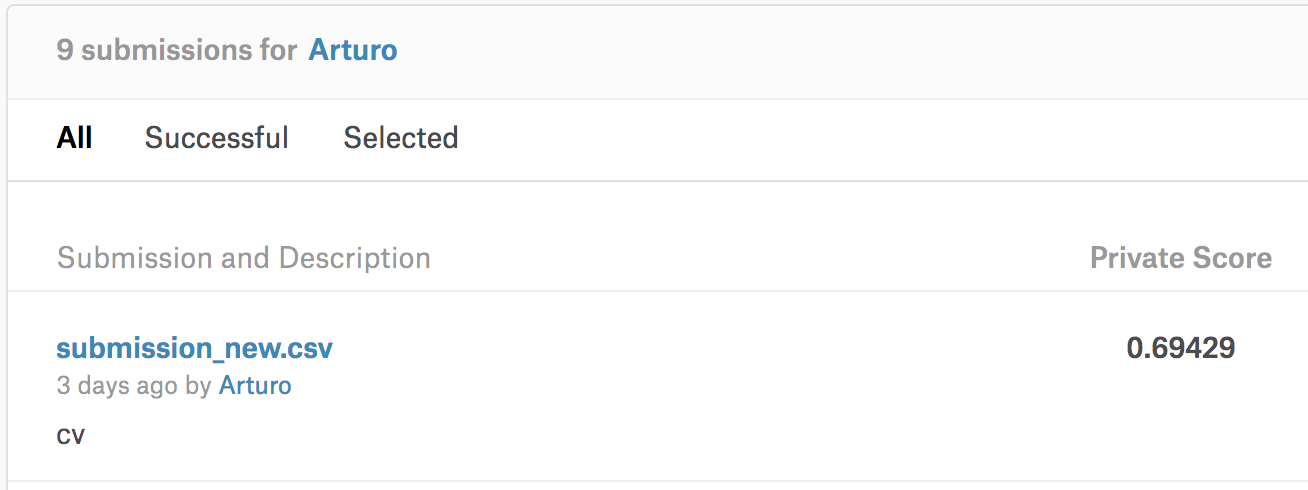

## Next Steps

One aspect in which we plan to spend additional time is on cleaning the data set and organizing the data. In particular, working on the time dataset to incorporate into the model the three separate time periods that compose the bids.csv data. 

Another important area of opportunity we detected focusing more on the time variable for example:
* Creating a more meaningful time variable.
* Analyzing the time between the last bids in an auction (rapid succession could indicate a sniping bot)
* Competition between two users in the same auction (could be a good predictor of shill bidding bots or sniping bots that bid as soon as they are outbid).
* The re-use of ip and url addresses that we know were used by a bot (if a bot used that ip, other bots are very likely to be using it too).
* Maximum number of bids per period of time.
* The stage at which the user most frequently makes his bids (begining, medium, end).
* Average number of known bots in auctions the bidder participates (if a user participates in an auction with a lot of bots he is likely a bot).

Finally, optimize our algorithms so that they run faster.